# Tech how-to: Build your own expected-goals model

This how-to guides you through the process of building your own expected-goals model using popular data science and machine learning tools like Pandas, XGBoost, and scikit-learn. In this how-to, we discuss the following steps:
1. Loading the data
2. Preparing the data
3. Constructing examples and datasets
4. Learning a model
5. Evaluating the model

As part of this how-to, we release an artificial but realistic shots dataset containing information on 127,643 shots. To represent the shots, we adopt the SPADL representation, which we introduce in more detail in the following paper:

**Actions Speak Louder Than Goals: Valuing Player Actions in Soccer**  
Tom Decroos, Lotte Bransen, Jan Van Haaren, and Jesse Davis  
[Read the full paper on arXiv](https://arxiv.org/abs/1802.07127)

In [1]:
%load_ext autoreload
%autoreload 2

# Import standard modules
import os
import sys

# Import Pandas library
import pandas as pd

# Import XGBoost classifier
from xgboost import XGBClassifier

# Import scikit-learn functions
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Import scikit-plot functions
from scikitplot.metrics import plot_roc_curve
from scikitplot.metrics import plot_precision_recall_curve
from scikitplot.metrics import plot_calibration_curve

# Import SciPy function
from scipy.spatial import distance

## Load the dataset

For the purpose of this how-to, we constructed an artificial but realistic shots dataset containing information on 127,643 shots. For each shot, the dataset contains the following information for the shot as well as the two actions immediately preceding the shot:
* `game_id`: a unique identifier of the game;
* `team_id`: a unique identifier of the team who performed the action;
* `player_id`: a unique identifier of the player who performed the action;
* `period`: 1 for the first half and 2 for the second half;
* `seconds`: the time elapsed in seconds since the start of the half;
* `type_id`: the identifier for the type of action;
* `type_name`: the name for the type of action;
* `body_part_id`: 0 for foot, 1 for head, 2 for other body part;
* `result`: the result of the action: 0 for failure, 1 for success;
* `start_x`: the x coordinate for the location where the action started, ranges from 0 to 105;
* `start_y`: the y coordinate for the location where the action started, ranges from 0 to 68;
* `end_x`: the x coordinate for the location where the action ended, ranges from 0 to 105;
* `end_y`: the y coordinate for the location where the action ended, ranges from 0 to 68.

The prefix `action` refers to the shot, whereas the prefixes `action1` and `action2` refer to the last and one-but-last action prior to the shot.

The mapping between the `type_id` and `type_name` values is as follows:
* 0: pass
* 1: cross
* 2: throw in
* 3: freekick crossed
* 4: freekick short
* 5: corner crossed
* 6: corner short
* 7: take on
* 8: foul
* 9: tackle
* 10: interception
* 11: shot
* 12: shot penalty
* 13: shot freekick
* 14: keeper save
* 18: clearance
* 21: dribble
* 22: goalkick

In [2]:
path_dataset = os.path.abspath(os.path.join(os.sep, os.getcwd(), os.pardir, 'data', 'scisports-shots.parquet'))

In [3]:
df_dataset = pd.read_parquet(path_dataset)

In [4]:
number_of_shots = len(df_dataset)

print('Our dataset contains {} shots.'.format(number_of_shots))

Our dataset contains 127643 shots.


In [5]:
df_dataset.columns

Index(['action_game_id', 'action_team_id', 'action_player_id', 'action_period',
       'action_seconds', 'action_type_id', 'action_type_name',
       'action_body_part_id', 'action_result', 'action_start_x',
       'action_start_y', 'action_end_x', 'action_end_y', 'action1_game_id',
       'action1_team_id', 'action1_player_id', 'action1_period',
       'action1_seconds', 'action1_type_id', 'action1_type_name',
       'action1_body_part_id', 'action1_result', 'action1_start_x',
       'action1_start_y', 'action1_end_x', 'action1_end_y', 'action2_game_id',
       'action2_team_id', 'action2_player_id', 'action2_period',
       'action2_seconds', 'action2_type_id', 'action2_type_name',
       'action2_body_part_id', 'action2_result', 'action2_start_x',
       'action2_start_y', 'action2_end_x', 'action2_end_y'],
      dtype='object')

## Normalize the location features

In order to help the learning algorithm, we rescale the location features from their original scales to a normalized scale ranging from 0 to 1. More specifically, we divide the x coordinates by 105 and the y coordinates by 68.

In [6]:
for action in ['action', 'action1', 'action2']:
    for side in ['start', 'end']:
        
        # Normalize the X location
        key_x = '{}_{}_x'.format(action, side)
        df_dataset[key_x] = df_dataset[key_x] / 105
               
        # Normalize the Y location
        key_y = '{}_{}_y'.format(action, side)
        df_dataset[key_y] = df_dataset[key_y] / 68

## Construct the examples

In order to predict the outcome of each shot, we need to transform our shots database into a dataset that we can fed into our machine learning algorithm. To this end, we perform the following three steps:

1. We compute the Eucledian distances between the start locations of each of the three actions and the center of the opposing goal. We add these three distances as features to our dataset as we expect them to help our machine learning algorithm to learn a more accurate model.

2. We construct our dataset by selecting a subset of the available features.

3. We split the dataset into a train set for training the model and a hold-out test set for evaluating the model. This is an important step as we aim to learn a predictive model that generalizes well to unseen examples. By evaluating our model on a hold-out test set, we can investigate whether we are overfitting on the train data.

### Compute additional features
We compute the Eucledian distances between the start location of each of the three actions and the center of the opposing goal, which is located at coordinates (1, 0.5) in our normalized coordinate representation.

In [7]:
# Normalized location for the center of the opposing goal
goal = (1, 0.5)

In [8]:
# Loop over the three actions
for action in ['action', 'action1', 'action2']:
    key_start_x = '{action}_start_x'.format(action=action)
    key_start_y = '{action}_start_y'.format(action=action)
    key_start_distance = '{action}_start_distance'.format(action=action)

    df_dataset[key_start_distance] = df_dataset.apply(lambda s: distance.euclidean((s[key_start_x], s[key_start_y]), goal), axis=1)

### Construct the dataset
We construct our dataset by selecting a subset of the available features. In this how-to, we use a limited number of features such as the location of the shot (`action_start_x` and `action_start_y`), the body part used by the shot taker (`action_body_part_id`), and the distances between the locations of the three actions and the center of the opposing goal (`action_start_distance`, `action1_start_distance`, and `action2_start_distance`).

We encourage you to try other features as well and to investigate what effect they have on the performance of your expected-goals model. For example, you could try to include the angle between the shot location and the center of the goal or the angle between the shot location and the goal posts as a feature too. 

In [9]:
# Features
columns_features = ['action_start_x', 'action_start_y', 'action_body_part_id', 'action_start_distance', 'action1_start_distance', 'action2_start_distance']

# Label: 1 if a goal, 0 otherwise
column_target = 'action_result'

In [10]:
X = df_dataset[columns_features]
y = df_dataset[column_target]

### Split the dataset into a train set and a test set
We train our expected-goals model on 90% of the data and evaluate the model on the remaining 10% of the data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

## Learn the model
We learn our expected-goals model using the XGBoost algorithm, which is a popular algorithm in machine learning competitions like Kaggle. The algorithm is particularly appealing as it requires minimal parameter tuning to provide decent performance on many standard machine learning tasks.

[Visit the XGBoost website for more information](http://xgboost.readthedocs.io/en/latest/model.html)

### Option 1: Train an XGBoost classifier using manually set hyperparameters
We train an XGBoost classifier on our train set. We train 100 trees and set their maximum depth to 5.

In [12]:
classifier = XGBClassifier(objective='binary:logistic', max_depth=5, n_estimators=100)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Option 2: Train an XGBoost classifier using grid search to automatically optimize the hyperparameters
We train an XGBoost classifier on our train set by performing a grid search over a set of reasonable hyperparameters to find the optimal hyperparameters for this task. We vary the maximum depths of the trees from 3 to 6 and try learning 100, 500, and 1000 trees. We use the default three-fold cross-validation approach to find the best set of hyperparameters.

We encourage you to explore different values for the hyperparameters as well. The following page offers an overview of the hyperparameters that can be tuned: [XGBoost Parameters](http://xgboost.readthedocs.io/en/latest/parameter.html). 

In [13]:
parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01],
    'n_estimators': [100, 500, 1000],
    'seed': [42]
}

classifier = XGBClassifier()
classifier = GridSearchCV(classifier, parameters, scoring='roc_auc', verbose=2)
classifier.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] learning_rate=0.01, max_depth=3, n_estimators=100, nthread=4, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, nthread=4, objective=binary:logistic, seed=42, total=   0.8s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100, nthread=4, objective=binary:logistic, seed=42 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, nthread=4, objective=binary:logistic, seed=42, total=   0.8s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100, nthread=4, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, nthread=4, objective=binary:logistic, seed=42, total=   0.8s
[CV] learning_rate=0.01, max_depth=3, n_estimators=500, nthread=4, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=500, nthread=4, objective=binary:logistic, seed=42, total=   4.4s
[CV] learning_rate=0.01, max_depth=3, n_estimators=500, nthread=4, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=500, nthread=4, objective=binary:logistic, seed=42, total=   4.3s
[CV] learning_rate=0.01, max_depth=3, n_estimators=500, nthread=4, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=500, nthread=4, objective=binary:logistic, seed=42, total=   4.5

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'nthread': [4], 'objective': ['binary:logistic'], 'max_depth': [3, 4, 5, 6], 'learning_rate': [0.01], 'n_estimators': [100, 500, 1000], 'seed': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

## Evaluate the model
We evaluate the accuracy of our expected-goals model by making predictions for the shots in our test set.

### Predict the test examples

In [14]:
# For each shot, predict the probability of the shot resulting in a goal
y_pred = classifier.predict_proba(X_test)

### Compute area under the curve: receiver operating characteristic (AUC-ROC)
To measure the accuracy of our expected-goals model, we compute the AUC-ROC obtained on the test set. The values for the AUC-ROC metric range from 0 to 1. The higher the AUC-ROC value is, the better the classifier is, where an AUC-ROC value of 0.50 corresponds to random guessing. That is, if we randomly predicted whether a shot results in a goal or not, we would obtain an AUC-ROC of 0.50.

In [15]:
y_total = y_train.count()
y_positive = y_train.sum()

print('The training set contains {} examples of which {} are positives.'.format(y_total, y_positive))

The training set contains 114878 examples of which 12261 are positives.


In [16]:
auc_roc = roc_auc_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-ROC of {}.'.format(auc_roc))

Our classifier obtains an AUC-ROC of 0.7782075125163256.


### Compute area under the curve: precision-recall (AUC-PR)
Since the AUC-ROC metric is susceptible to class imbalance (i.e., the number of positive examples is much lower or higher than the number of negative examples), we also compute the AUC-PR obtained on the test set. The values for the AUC-PR metric range from 0 to 1 too. The higher the AUC-PR value is, the better the classifier is. Unlike AUC-ROC, however, the value for random guessing does not necessarily correspond to 0.50 for imbalanced classes, but corresponds to the ratio of positive examples in the train set.

In [17]:
auc_pr_baseline = y_positive / y_total

print('The baseline performance for AUC-PR is {}.'.format(auc_pr_baseline))

The baseline performance for AUC-PR is 0.10673061856926479.


In [18]:
auc_pr = average_precision_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-PR of {}.'.format(auc_pr))

Our classifier obtains an AUC-PR of 0.3538757506049751.


### Plot AUC-ROC curve

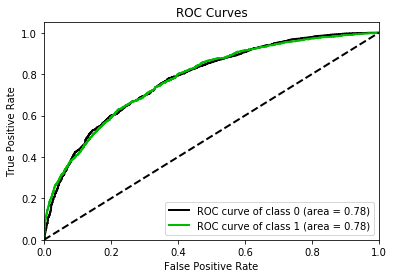

In [19]:
plot_roc_curve(y_test, y_pred, curves='each_class')

### Plot AUC-PR curve

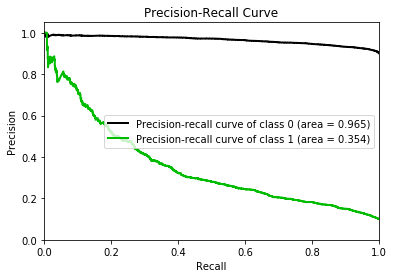

In [20]:
plot_precision_recall_curve(y_test, y_pred, curves='each_class')

### Plot calibration curve
We plot a calibration curve to investigate how well our expected-goals model is calibrated. The plot shows the mean predicted value on the horizontal axis and the fraction of covered positive examples on the vertical axis.

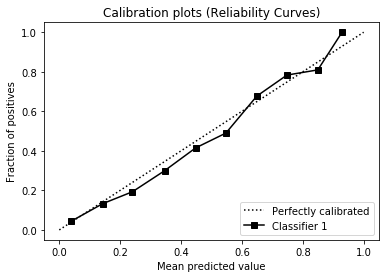

In [21]:
plot_calibration_curve(y_test, [y_pred])